# Introduction to General Linear Modeling (GLM)  


In [5]:

%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf



## Simulate time-series from a voxel 

First create synthetic data that simulates a time series for a single voxel. Knowing the ground truth of the signal, 
we can evaluate how well we can recover the true signal using a glm.   
We will simulate a trial based experiment. First specify the number of volumes in the time series. Then specify the timepoint in which
the trial is presented, and then specify the time-point which the trial is presented. 

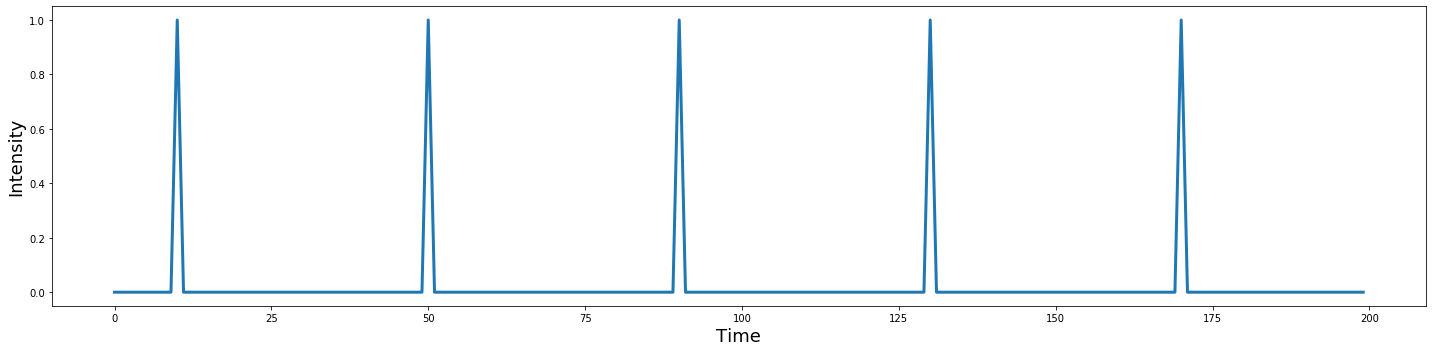

In [6]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1

def plot_timeseries(data, labels=None, linewidth=3):
    '''Plot a timeseries
    
    Args:
        data: (np.ndarray) signal varying over time, where each column is a different signal.
        labels: (list) labels which need to correspond to the number of columns.
        linewidth: (int) thickness of line
    '''
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        if len(labels) != data.shape[1]:
            raise ValueError('Need to have the same number of labels as columns in data.')
        plt.legend(labels, fontsize=18)
    
plot_timeseries(face)


We now have 5 events where a face is shown for 2 seconds (i.e., one TR). If we scanned someone with this design,
we might expect to see any region involved in processing faces increase in activation around the time of the face presentation.
How would we know which of these regions, if any, selectively process faces? Many of the regions we would observe are likely 
involved in processing any visual stimulus, and not specifically faces.

To rule out this potential confound, we would need at least one other condition that would serve as a visual control.
Something that might have similar properties to a face, but isn't a face.

One possibility is to create a visual stimulus that has all of the same visual properties in terms of luminance and color,
but no longer resembles a face. Here is an example of the same faces that have been Fourier transformed, phase-scrambled,
and inverse Fourier transformed. These pictures have essentially identical low level visual properties, but are clearly not faces.
Both of these conditions could serve as a different type of visual control. To keep things simple, let's start with pictures of objects
as it controls for low level visual features, but also more complex object processing.

To demonstrate that a region is processing faces and not simply lower level visual properties or objects more generally, we can search
for regions that are selectively more activated in response to viewing faces relative to objects. This is called a contrast and is the
basic principle of the subtraction method for controlling for potential experimental confounds. Because BOLD fMRI is a relative and not 
absolute measure of brain activity, the subtraction method is a key aspect of experimental design.


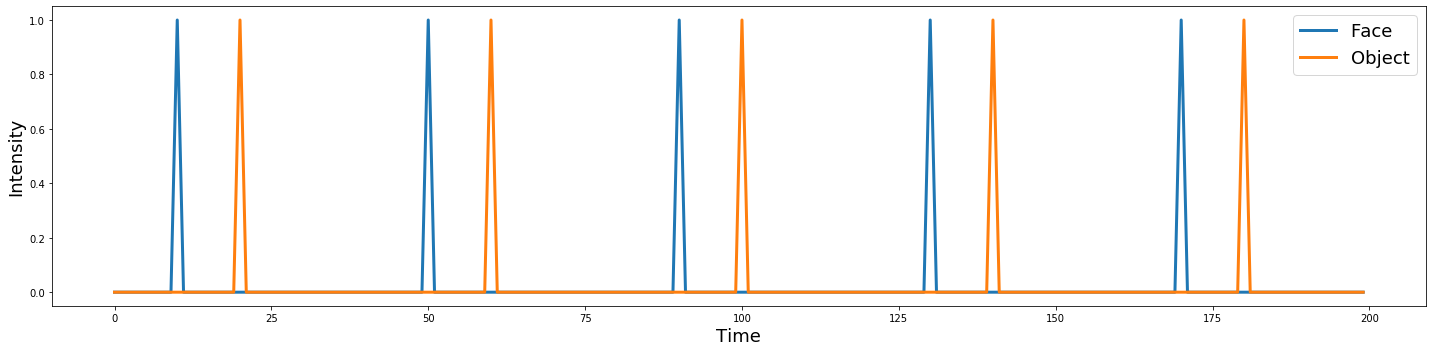

In [7]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])



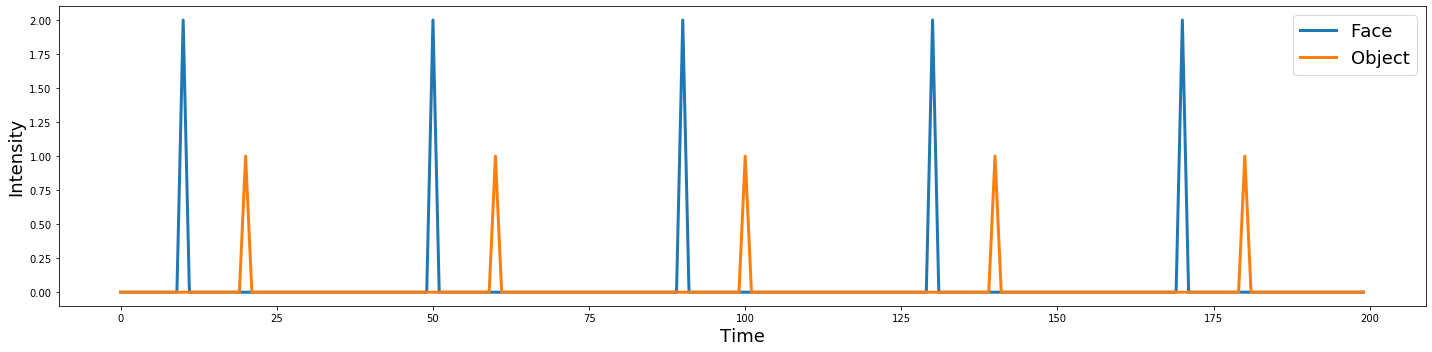

In [8]:
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])


Ok, now we have two conditions that are alternating over time.

We know that the brain has a **delayed hemodynamic response** to events that has a particular shape, so we will need to convolve
these events with an appropriate HRF function. Here, we will use the double-gamma HRF function.

Text(0.5, 0, 'Time')

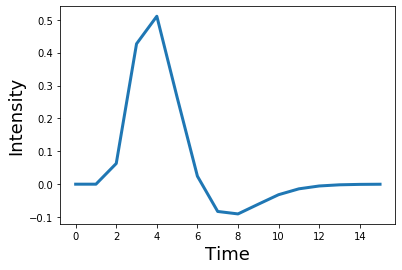

In [9]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

We will use np.convolve from numpy to perform the convolution. The length of the convolved data will be the length of the time series plus
the length of the kernel minus 1. To make sure everything is the same length, we will chop off the extra time off the convolved time series
 using mode='same'.

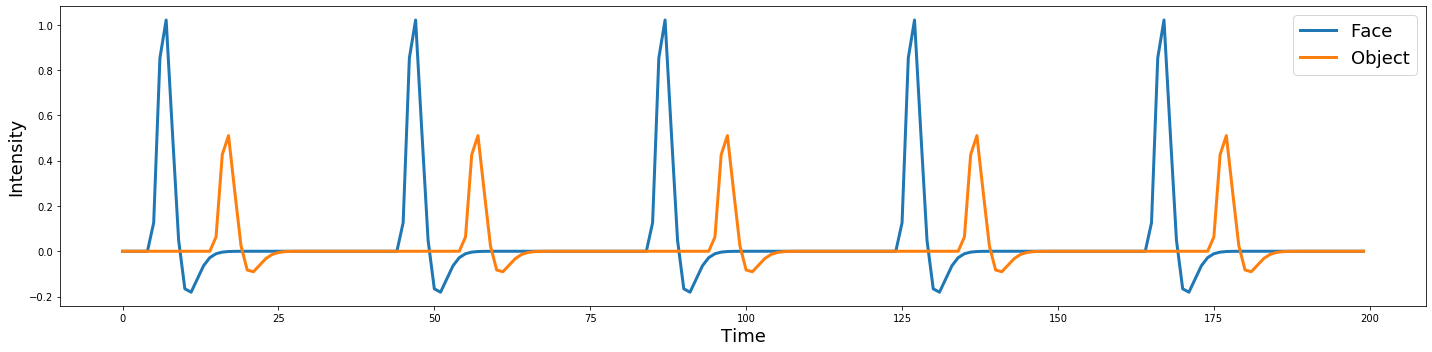

In [10]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(voxel_conv, labels=['Face', 'Object'])



While this might reflect the expected HRF response to a single event, real data is much noiser. It is easy to add different types of noise. 
For example, there might be a low frequency drift, autocorrelation, or possibly some aliased physiological artifacts.

For now, let's start with something simple, like independent white noise drawn from a random Gaussian distribution , u=0, sigma=0.15

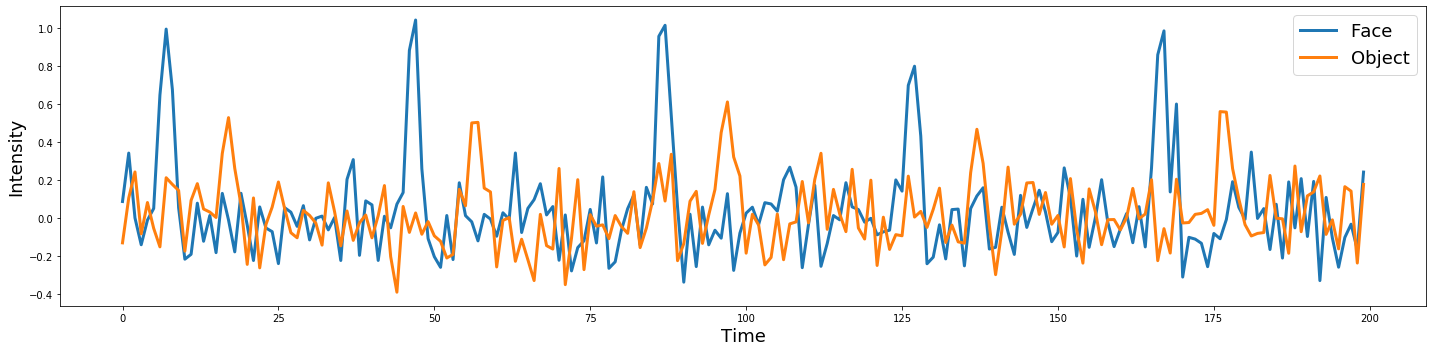

In [11]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise, labels=['Face', 'Object'])



Now this is looking much more like real BOLD activity.

Remember, the goal of this exercise is to generate simulated activity from a voxel. If we were to extract signal from a specific voxel we wouldn't know which condition was which, so let's combine these two signals into a single simulated voxel timeseries by adding the two vectors together with the .sum() method.

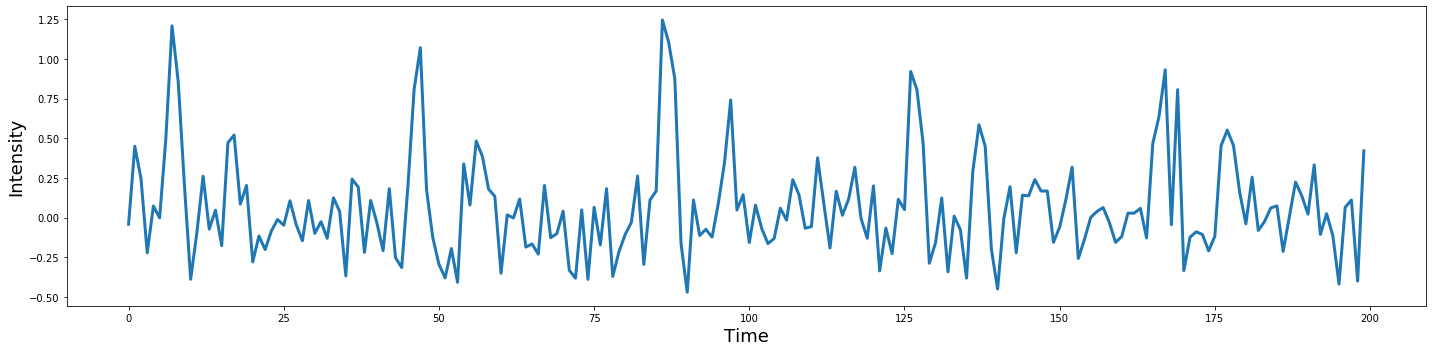

In [12]:
Y = voxel_conv_noise.sum(axis=1)

plot_timeseries(Y)


